In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from itertools import product
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
# Load dataset
data = "https://raw.githubusercontent.com/indescared/otwsarjana/main/data%20penjualan.xlsx"
df = pd.read_excel(data)
df['tanggal'] = pd.to_datetime(df['tanggal'])
df = df.sort_values(by='tanggal')

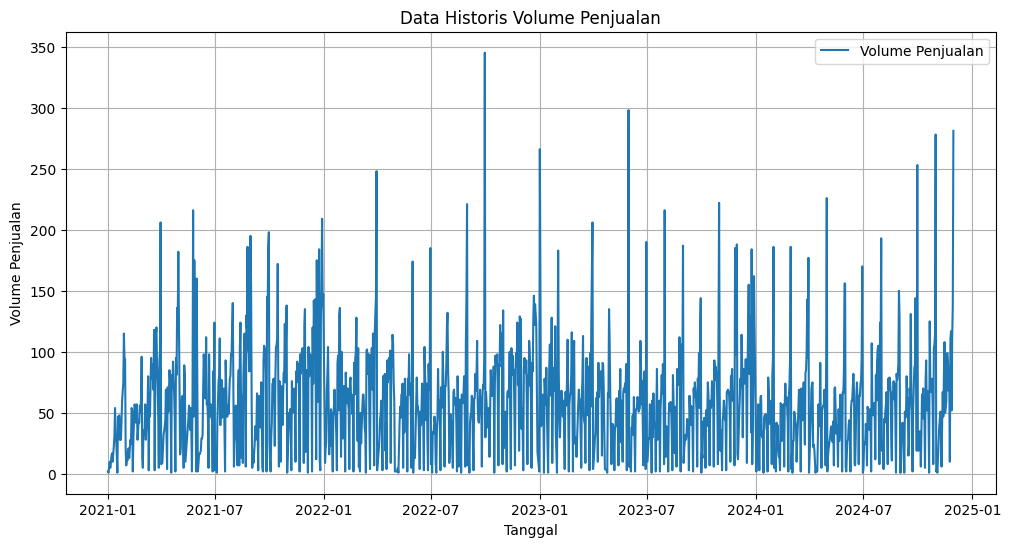

In [ ]:
# Visualize data
plt.figure(figsize=(12, 6))
plt.plot(df['tanggal'], df['volume penjualan'], label='Volume Penjualan')
plt.title('Data Historis Volume Penjualan')
plt.xlabel('Tanggal')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Perform ADF Test
adf_test = adfuller(df['volume penjualan'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])
if adf_test[1] < 0.05:
    print("Data stasioner.")
else:
    print("Data tidak stasioner.")

ADF Statistic: -8.531281170810965
p-value: 1.0360582293701173e-13
Critical Values: {'1%': np.float64(-3.435170967430817), '5%': np.float64(-2.8636690928667523), '10%': np.float64(-2.5679035297726274)}
Data stasioner.


In [ ]:
# Menentukan ukuran data training
train_size = int(len(df) * 0.8)  # Use len(df) instead of len(data)

# Membagi data menjadi data training dan testing
X_train = df.iloc[:train_size][['tanggal']]  # Use df instead of data
y_train = df.iloc[:train_size]['volume penjualan']

X_test = df.iloc[train_size:][['tanggal']]  # Use df instead of data
y_test = df.iloc[train_size:]['volume penjualan']

# Mengecek bentuk data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1099, 1)
y_train shape: (1099,)
X_test shape: (275, 1)
y_test shape: (275,)


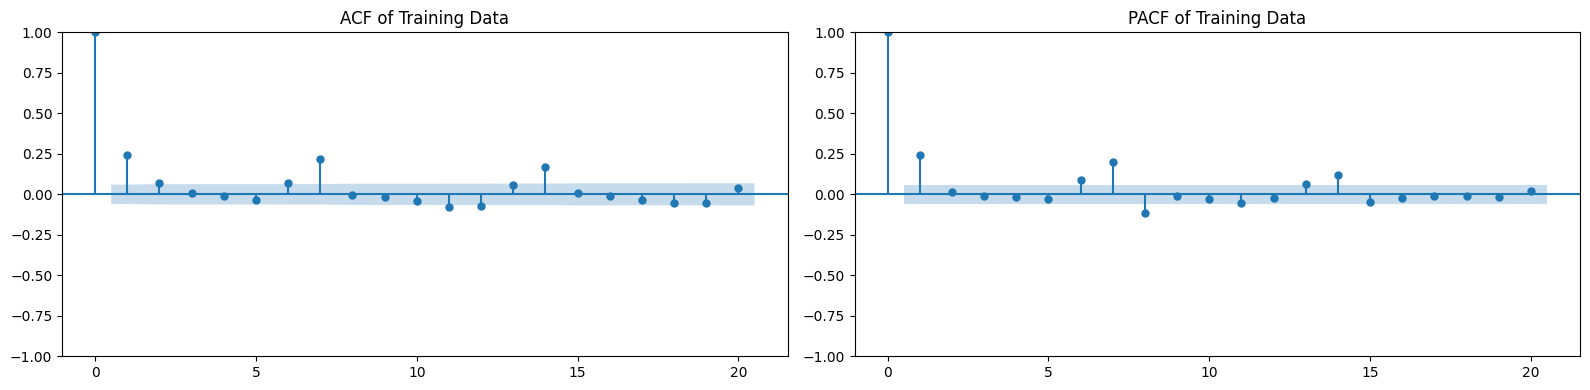

In [ ]:
# Plot ACF and PACF for the training data
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(y_train, ax=axes[0], lags=20)  # Adjust lags as needed
axes[0].set_title('ACF of Training Data')

plot_pacf(y_train, ax=axes[1], lags=20)  # Adjust lags as needed
axes[1].set_title('PACF of Training Data')

plt.tight_layout()
plt.show()

In [ ]:
# Define parameters
p = range(0, 2)
d = [0]
q = range(0, 2)
parameters = list(product(p, d, q))
results_combined = []

# Perform grid search using only training data and AIC
for param in parameters:
    try:
        model = ARIMA(y_train, order=param).fit()  # Fit on y_train only
        results_combined.append((param, model.aic))
    except:
        continue

# Sort the results by AIC in ascending order and get the top 5
results_combined.sort(key=lambda x: x[1])
top_5_results = results_combined[:5]

# Print the top 5 results
print("Top 5 best parameters (p, d, q) and their AIC:")
for param, aic in top_5_results:
    print(f"Parameters: {param}, AIC: {aic}")


Top 5 best parameters (p, d, q) and their AIC:
Parameters: (1, 0, 0), AIC: 11315.713705989996
Parameters: (1, 0, 1), AIC: 11317.547300815655
Parameters: (0, 0, 1), AIC: 11321.003483415692
Parameters: (0, 0, 0), AIC: 11380.6903702406


In [ ]:
# Train ARIMA with the best parameters
best_order = best_params[0]  # Extract the best order from best_params
arima_model_best = ARIMA(y_train, order=best_order).fit()
# Summary of the model
print(arima_model_best.summary())
# Add predictions to DataFrame
df['arima_predictions'] = arima_model_best.fittedvalues
# lakukan seperti ini tapi menggunakan data train and test

# Train the ARIMA model on the training data
arima_model_best = ARIMA(y_train, order=best_order).fit()

# Make predictions on the test data
predictions = arima_model_best.predict(start=len(y_train), end=len(df)-1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Add predictions to the DataFrame (for the entire dataset)
df['arima_predictions'] = arima_model_best.predict(start=0, end=len(df)-1)

                               SARIMAX Results                                
Dep. Variable:       volume penjualan   No. Observations:                 1099
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5654.857
Date:                Thu, 17 Apr 2025   AIC                          11315.714
Time:                        03:36:32   BIC                          11330.720
Sample:                             0   HQIC                         11321.391
                               - 1099                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6324      1.963     30.373      0.000      55.784      63.480
ar.L1          0.2432      0.021     11.751      0.000       0.203       0.284
sigma2      1723.7251     47.879     36.002      0.0

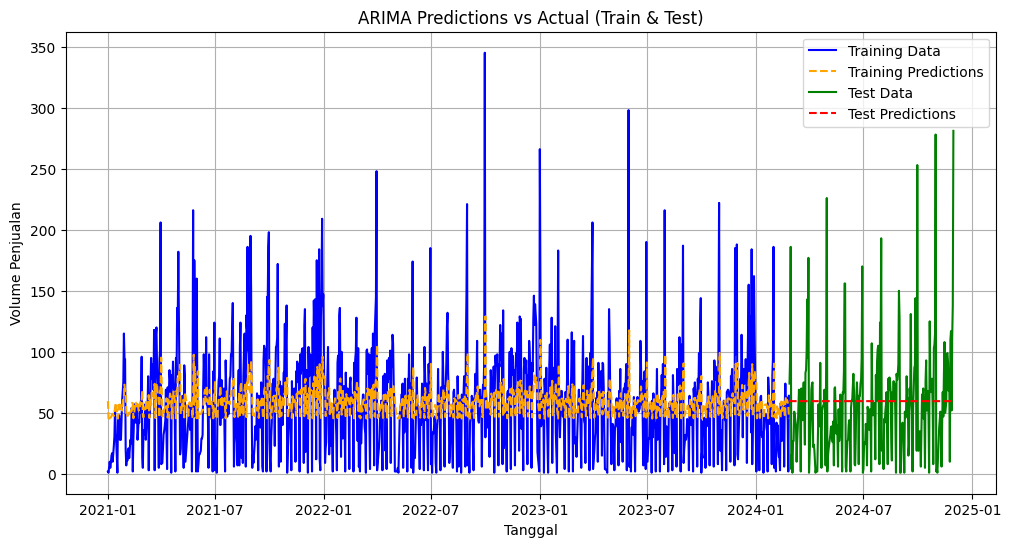

In [ ]:
# Visualize predictions on train and test data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(X_train['tanggal'], y_train, label='Training Data', color='blue')

# Plot predictions on training data
plt.plot(X_train['tanggal'], arima_model_best.fittedvalues, label='Training Predictions', color='orange', linestyle='--')

# Plot test data
plt.plot(X_test['tanggal'], y_test, label='Test Data', color='green')

# Plot predictions on test data
plt.plot(X_test['tanggal'], predictions, label='Test Predictions', color='red', linestyle='--')


plt.title('ARIMA Predictions vs Actual (Train & Test)')
plt.xlabel('Tanggal')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate evaluation metrics for training data
train_predictions = arima_model_best.fittedvalues
rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
mae_train = mean_absolute_error(y_train, train_predictions)
mape_train = (abs(y_train - train_predictions) / y_train).mean() * 100

print("ARIMA Evaluation Metrics (Training Data):")
print("RMSE:", rmse_train)
print("MAE:", mae_train)
print("MAPE:", mape_train)


# You already have the evaluation metrics for the test data calculated previously:
print("\nARIMA Evaluation Metrics (Test Data):")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Calculate MAPE for test data
mape_test = (abs(y_test - predictions) / y_test).mean() * 100
print(f"MAPE: {mape_test}")

ARIMA Evaluation Metrics (Training Data):
RMSE: 41.5352331367634
MAE: 30.33246400214015
MAPE: 344.08838090077495

ARIMA Evaluation Metrics (Test Data):
RMSE: 44.58402399391456
MAE: 31.897026298047308
MAPE: 438.5456098326339


In [ ]:
# Grid search over all combinations of parameters
p = [1]
d = [0]
q = [0]

P = range(0, 2)
D = [0]
Q = range(0, 2)
s = [7]

# Track the best model
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

for param in [(i, j, k) for i in p for j in d for k in q]:
    for seasonal_param in [(i, j, k, l) for i in P for j in D for k in Q for l in s]:
        try:
            model = SARIMAX(y_train,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
                best_model = results
        except:
            continue

# Print the best model parameters
print("Best SARIMA Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
print("Best AIC:", best_aic)

Best SARIMA Order: (1, 0, 0)
Best Seasonal Order: (1, 0, 1, 7)
Best AIC: 11236.625684717292


In [ ]:
# Define SARIMA parameters
order = (1, 0, 0)              # Non-seasonal parameters
seasonal_order = (1, 0, 1, 7)  # Seasonal parameters (weekly seasonality)

# Fit SARIMA model
model = SARIMAX(y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_results = model.fit(disp=False)

In [ ]:
# Get predictions for SARIMA
sarima_train_predictions = sarima_results.fittedvalues
sarima_test_predictions = sarima_results.forecast(steps=len(y_test))

In [ ]:
# Calculate SARIMA evaluation metrics
sarima_mape_train = mean_absolute_percentage_error(y_train, sarima_train_predictions)
sarima_mape_test = mean_absolute_percentage_error(y_test, sarima_test_predictions)
sarima_rmse_train = mean_squared_error(y_train, sarima_train_predictions)**0.5
sarima_rmse_test = mean_squared_error(y_test, sarima_test_predictions)**0.5
sarima_mae_train = mean_absolute_error(y_train, sarima_train_predictions)
sarima_mae_test = mean_absolute_error(y_test, sarima_test_predictions)

# Print SARIMA results
print("SARIMA Model Order:", order)
print("SARIMA Seasonal Order:", seasonal_order)
print("SARIMA Train MAPE:", sarima_mape_train)
print("SARIMA Test MAPE:", sarima_mape_test)
print("SARIMA Train RMSE:", sarima_rmse_train)
print("SARIMA Test RMSE:", sarima_rmse_test)
print("SARIMA Train MAE:", sarima_mae_train)
print("SARIMA Test MAE:", sarima_mae_test)

SARIMA Model Order: (1, 0, 0)
SARIMA Seasonal Order: (1, 0, 1, 7)
SARIMA Train MAPE: 2.6177575301210356
SARIMA Test MAPE: 2.5577121543135384
SARIMA Train RMSE: 41.32187080728806
SARIMA Test RMSE: 49.112124919278706
SARIMA Train MAE: 29.795690728549236
SARIMA Test MAE: 34.06200534243212


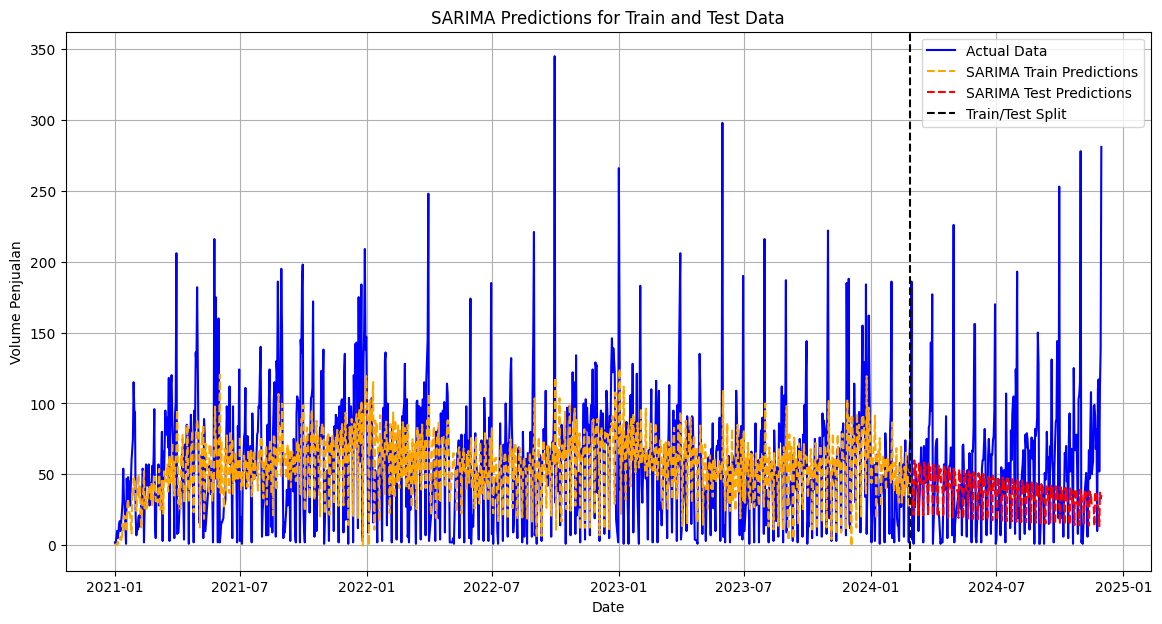

In [ ]:
# Plot actual vs predictions
plt.figure(figsize=(14, 7))
plt.plot(df['tanggal'], df['volume penjualan'], label='Actual Data', color='blue')
plt.plot(X_train['tanggal'], sarima_train_predictions, label='SARIMA Train Predictions', color='orange', linestyle='--')
plt.plot(X_test['tanggal'], sarima_test_predictions, label='SARIMA Test Predictions', color='red', linestyle='--')
plt.axvline(x=X_test['tanggal'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.title('SARIMA Predictions for Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.show()

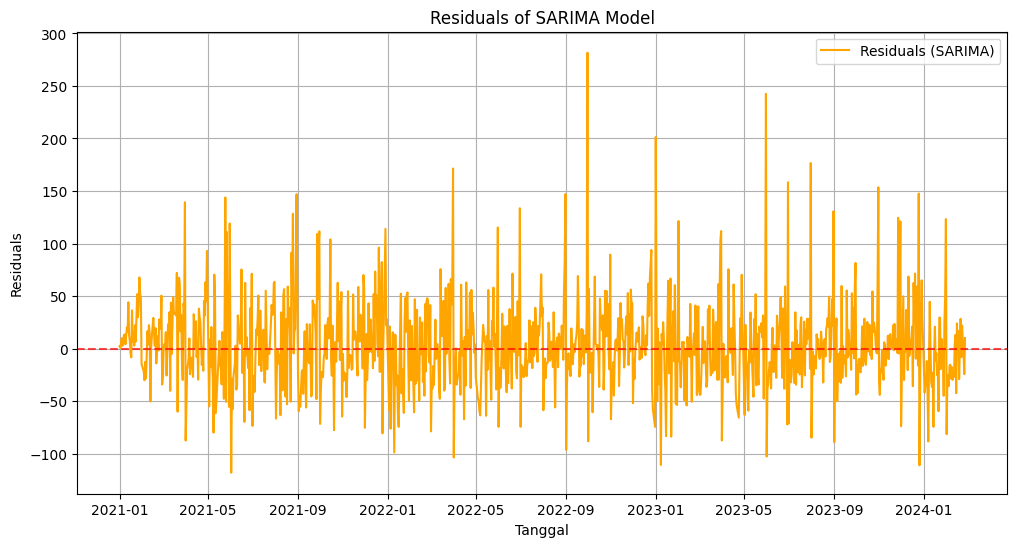

In [ ]:
# Residuals analysis
sarima_residuals = y_train - sarima_train_predictions
plt.figure(figsize=(12, 6))
plt.plot(X_train['tanggal'], sarima_residuals, label='Residuals (SARIMA)', color='orange')
plt.axhline(0, linestyle='--', color='red', alpha=0.7)
plt.title('Residuals of SARIMA Model')
plt.xlabel('Tanggal')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Ljung-Box Test for SARIMA
ljung_box_sarima = acorr_ljungbox(sarima_residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box Test Results for SARIMA:")
print(ljung_box_sarima)

Ljung-Box Test Results for SARIMA:
      lb_stat  lb_pvalue
10  15.549971    0.11326


In [ ]:
# Predict future values using SARIMA model
forecast_steps = 30
sarima_forecast = sarima_results.forecast(steps=forecast_steps)
forecast_dates_sarima = pd.date_range(start=df['tanggal'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Create DataFrame for future predictions
forecast_df = pd.DataFrame({
    'Tanggal': forecast_dates_sarima,
    'SARIMA Prediksi Volume Penjualan': sarima_forecast
})

In [ ]:
# prompt: BUATKAN FORECAST 30 HARI KEDEPAN

import matplotlib.pyplot as plt
# Display the forecast
print("\nSARIMA Forecast for the next 30 days:")
print(forecast_df)

# Plot historical data and SARIMA forecast
plt.figure(figsize=(14, 7))
plt.plot(df['tanggal'], df['volume penjualan'], label='Historical Data', color='blue')
plt.plot(forecast_df['Tanggal'], forecast_df['SARIMA Prediksi Volume Penjualan'], label='SARIMA Forecast', color='red', linestyle='--')
plt.title('Historical Data and SARIMA Forecast for Volume Penjualan')
plt.xlabel('Tanggal')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.show()

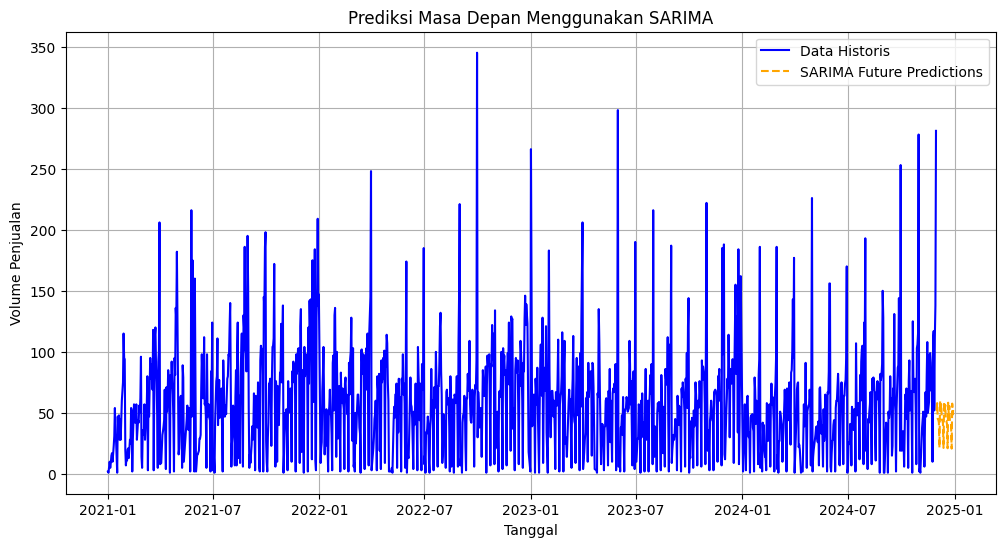

        Tanggal  SARIMA Prediksi Volume Penjualan
1099 2024-12-01                         52.058145
1100 2024-12-02                         58.004820
1101 2024-12-03                         44.966584
1102 2024-12-04                         44.576902
1103 2024-12-05                         41.951307
1104 2024-12-06                         21.557671
1105 2024-12-07                         59.818550
1106 2024-12-08                         50.600781
1107 2024-12-09                         57.088946
1108 2024-12-10                         44.360251
1109 2024-12-11                         44.010592
1110 2024-12-12                         41.426108
1111 2024-12-13                         21.288511
1112 2024-12-14                         59.073280
1113 2024-12-15                         49.970445
1114 2024-12-16                         56.377819
1115 2024-12-17                         43.807684
1116 2024-12-18                         43.462382
1117 2024-12-19                         40.910091


In [ ]:
# Visualize future predictions
plt.figure(figsize=(12, 6))
plt.plot(df['tanggal'], df['volume penjualan'], label='Data Historis', color='blue')
plt.plot(forecast_dates_sarima, sarima_forecast, label='SARIMA Future Predictions', color='orange', linestyle='--')
plt.title('Prediksi Masa Depan Menggunakan SARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.show()

# Display the future forecast DataFrame
print(forecast_df)
